In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import pyranges as pr
from PyWGCNA import WGCNA
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
import igraph as ig
import leidenalg as la
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import scanpy
import colorcet as cc
import seaborn as sns
import powerlaw
import scipy.stats
from fitter import Fitter
from gprofiler import GProfiler
from typing import Union
import re
from collections import Counter
%matplotlib inline

In [2]:
def list_domain_todf(list_domain):
    chrom = [x.split(':')[0] for x in list_domain]
    start = [re.split(':|-', x)[1] for x in list_domain]
    end = [re.split(':|-', x)[2] for x in list_domain]
    return pd.DataFrame({'Chromosome': chrom, 
                         'Start': start, 'End':end}, index=list_domain)

In [3]:
def filter_allzero(df):
    cols = df.columns
    df_sum = df.sum(0)
    masked = cols[df_sum>0]
    return df[masked]

In [4]:
def correlation_cal(data, test='spearmanr', fillna=0, pval=False):
    if test == 'spearmanr':
        if not pval:
            scaled_corr, _ = spearmanr(data)
        else:
            scaled_corr, pval = spearmanr(data)
    elif test == 'pearsonr':
        if not pval:
            scaled_corr = np.corrcoef(data.to_numpy().T)
        else:
            raise ValueError("not support pval for pearsonr")
    else:
        raise ValueError('Not supported: choose between pearsonr or spearmanr')
         

    np.fill_diagonal(scaled_corr, 1)
    scaled_corr = pd.DataFrame(scaled_corr, index=data.columns, columns=data.columns)
    scaled_corr.fillna(fillna, inplace=True)
    if not pval:
        return scaled_corr
    else:
        return (scaled_corr, pval)

In [5]:
def rank_transformation(data, scaled='MinMax'):
    """ Rank transformation and scale across assays
        Arguments:
            data (pd.DataFrame): samples x features
            scaled (str): type of scaler to scale data across sample
                (default: MinMax)
                None: for not using scale     
    """
    rank_transform = data.to_numpy().argsort().argsort()
    if not scaled:
        return pd.DataFrame(rank_transform, 
                                    index=data.index,
                                    columns=data.columns)
    else:
        scaler = MinMaxScaler()
        scaler.fit(rank_transform)
        df = pd.DataFrame(scaler.transform(rank_transform), 
                                        index=data.index,
                                        columns=data.columns) 
        return df

In [6]:
def powerlaw_fit_plot(corr_df, 
                    power, 
                    title: str,
                    threshold=None, 
                    sfti: Union['connectivity', 'degree'] = 'connectivity'):
    unsigned_corr = abs(corr_df.to_numpy())
    TOMsim_signed = unsigned_corr**power

    if threshold: 
        q=np.quantile(upper, 0.99)
        print(q3)
        fil = np.where(TOMsim_signed<q, 0, TOMsim_signed)
    else:
        fil=TOMsim_signed

    fil=pd.DataFrame(TOMsim_signed, index=corr_df.index, columns=corr_df.columns)
    graph = ig.Graph.Weighted_Adjacency(fil, 'upper', loops=False)
    print(f'{graph.vcount()} nodes, {graph.ecount()} edges')
    if sfti == 'connectivity':
        print(f'Mean connectivity: {np.sum(graph.strength(weights="weight"))/graph.vcount()}')
        _sequence = sorted(graph.strength(weights='weight'), reverse=True)
        _sequence = np.round(_sequence)
    elif sfti == 'degree':
        print(f'Mean connectivity: {np.sum(graph.degree())/graph.vcount()}')
        _sequence = sorted(graph.degree(), reverse=True)
    
    fig, ax = plt.subplots(figsize=(10,7))
    plt.yscale('log')
    plt.xscale('log')

    fit = powerlaw.Fit(_sequence)
    print(fit.power_law.alpha, fit.power_law.sigma, fit.xmin)
    print(fit.distribution_compare('power_law',  'lognormal', normalized_ratio=True))
    deg = _sequence
    deg_distri = Counter(deg)
    x=[]
    y=[]
    for i in sorted(deg_distri):
            x.append(i)
            y.append(deg_distri[i]/graph.vcount())
    ax.plot(x, y,'ro')
    fig=fit.plot_pdf(color='r', label='data', ax=ax)
    fit.power_law.plot_pdf(color='b', linestyle='-', linewidth=1, label='powerlaw fit', ax=ax)
    fit.lognormal.plot_pdf(color='g', linestyle='-', linewidth=1, label='lognormal fit', ax=ax)
    fig.legend(fontsize=13)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=22)
    plt.xlabel(f'{sfti} $k$', fontsize=22)
    plt.ylabel('$P(k)$', fontsize=22)
    plt.title(title)
    ax.text(0.7, 1.0, f'$\\alpha$={(round(fit.alpha, 2))}, xmin={fit.xmin}', transform=ax.transAxes, fontdict={'size': 13})
    plt.savefig(f'{title}.png')


In [7]:
def module_trait_relationships_heatmap(pywgcna_obj,
                                        file_name: str,
                                        plot_title: str,
                                        metaData=['Tissue'],
                                        show=True,
                                           ):
        """
        plot topic-trait relationship heatmap

        :param metaData: traits you would like to see the relationship with topics (must be column name of datExpr.obs)
        :type metaData: list
        :param show: indicate if you want to show the plot or not (default: True)
        :type show: bool
        :param file_name: name and path of the plot use for save (default: topic-traitRelationships)
        :type file_name: str
        """
        datTraits = pywgcna_obj.getDatTraits(metaData)
        pvalue = pywgcna_obj.moduleTraitPvalue.loc[:, datTraits.columns]
        cor = pywgcna_obj.moduleTraitCor.loc[:, datTraits.columns]

        fig, ax = plt.subplots(figsize=(max(20, int(pvalue.shape[0] * 1.5)),
                                        pvalue.shape[1] * 1.5), facecolor='white')
        # names
        xlabels = []
        for label in pywgcna_obj.MEs.columns:
            xlabels.append(label[2:].capitalize() + '(' + str(sum(pywgcna_obj.datExpr.var['moduleColors'] == label[2:])) + ')')
        ylabels = datTraits.columns

        # Loop over data dimensions and create text annotations.
        tmp_cor = cor.T.round(decimals=2)
        tmp_pvalue = pvalue.T.round(decimals=3)
        labels = (np.asarray(["{0}\n({1})".format(cor, pvalue)
                              for cor, pvalue in zip(tmp_cor.values.flatten(),
                                                     tmp_pvalue.values.flatten())])) \
            .reshape(cor.T.shape)

        sns.set(font_scale=1.5)
        res = sns.heatmap(cor.T, annot=labels, fmt="", cmap='RdBu_r',
                          vmin=-1, vmax=1, ax=ax, annot_kws={'size': 20, "weight": "bold"},
                          xticklabels=xlabels, yticklabels=ylabels)
        res.set_xticklabels(res.get_xmajorticklabels(), fontsize=20, fontweight="bold", rotation=90)
        res.set_yticklabels(res.get_ymajorticklabels(), fontsize=20, fontweight="bold")
        plt.yticks(rotation=0)
        ax.set_title(plot_title,
                     fontsize=30, fontweight="bold")
        ax.set_facecolor('white')
        fig.tight_layout()

        plt.savefig(f'{file_name}.png')

--------------

In [9]:
mainpath='network_dataframe_majortissue' #path pls 

In [10]:
target = ['H3K4me3', 'H3K27me3', 'H3K4me1', 'H3K27ac', 'H3K9me3']

In [11]:
adata_files = [f for f in os.listdir(mainpath) if '.h5ad' in f and 'chr1.' in f]

In [12]:
adata_files

['adata_hm_tissue_chr1.h5ad']

In [13]:
color_p = cc.glasbey_warm

In [14]:
for f in adata_files:
    adata = scanpy.read_h5ad(f'{mainpath}/{f}')
    chrom = re.split('_|\.', f)[3]
    for h in target:
        print(h)
        hm = adata[adata.obs['Target of assay']=='H3K4me1']
        hm_info = hm.obs
        hm = hm.to_df('average_signal')
        hm = filter_allzero(hm)

        hm_info = adata.obs.query(f'`Target of assay` == "H3K4me1"')

        rank_full = rank_transformation(hm)
        corr_full = correlation_cal(rank_full, 'pearsonr')
        print(corr_full.shape)
        break
        
        power, _ = WGCNA.pickSoftThreshold(rank_full, 'unsigned')

        powerlaw_fit_plot(corr_df=corr_full, power=power, title=f'Power fit {h} - {chrom}')

        pyWGCNA_hm = WGCNA(name=h, 
                              species='homo sapiens', 
                              geneExp=rank_full,
                              networkType='unsigned',)
        pyWGCNA_hm.findModules()

        pyWGCNA_hm.updateSampleInfo(hm_info)

        tissue_color = dict(zip(hm_info.Tissue.unique().tolist(), color_p))

        pyWGCNA_hm.setMetadataColor('Tissue', tissue_color)
        pyWGCNA_hm.analyseWGCNA()

        module_trait_relationships_heatmap(pywgcna_obj=pyWGCNA_hm, plot_title=f"Module-Trait relationships heatmap for {h} - {chrom}", file_name=f'module_trait_{h}_{chrom}')

        list_regions = []
        for name in pyWGCNA_hm.getModuleName():
            list_regions.append(pyWGCNA_hm.top_n_hub_genes(name, n=-1))
        list_regions_df = pd.concat(list_regions, axis=0)
        list_regions_df.reset_index().to_feather(f'{h}_{chrom}_wgcna_region.feather')
        break
    break


H3K4me3
(34372, 34372)


In [1]:
from PyWGCNA import WGCNA


In [3]:
WGCNA.TOMsimilarity?

Signature: WGCNA.TOMsimilarity(adjMat, TOMType='signed', TOMDenom='min')
Docstring:
Calculation of the topological overlap matrix, and the corresponding dissimilarity, from a given adjacency matrix

:param adjMat: adjacency matrix, that is a square, symmetric matrix with entries between 0 and 1 (negative values are allowed if TOMType=="signed").
:type adjMat: pandas dataframe
:param TOMType: one of "unsigned", "signed"
:type TOMType: str
:param TOMDenom: a character string specifying the TOM variant to be used. Recognized values are "min" giving the standard TOM described in Zhang and Horvath (2005), and "mean" in which the min function in the denominator is replaced by mean. The "mean" may produce better results but at this time should be considered experimental.
:type TOMDenom: str

:return: A matrix holding the topological overlap.
:rtype: pandas dataframe
File:      ~/anaconda3/lib/python3.9/site-packages/PyWGCNA/wgcna.py
Type:      function


In [80]:
import plotly.express as px
from plotly.subplots import make_subplots
import os
import scanpy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [27]:
adatas_file = [x for x in os.listdir('network_dataframe_majortissue/') if '.h5ad' in x]
chromosome = {}
for f in adatas_file:
    chrom = f.split('_')[3].split('.')[0]
    reading = scanpy.read_h5ad(f'network_dataframe_majortissue/{f}')
    chromosome[chrom] = reading

In [28]:
target = ['H3K4me3','H3K4me1', 'H3K9me3', 'H3K27me3', 'H3K27ac']

In [117]:
chrom_list = [f'chr{i}' for i in range(1,23)]

In [151]:
for h in target:
    hm_tissue = chromosome['chr1'].obs.query(f'`Target of assay` == "{h}"').Tissue.unique()
    tissue = {}
    for t in hm_tissue:
        tissue[t] = {}    
        for i in range(1, 23):
            chrom = f'chr{i}'
            sc_data = chromosome[chrom]
            sub = sc_data[(sc_data.obs['Tissue']==t) & (sc_data.obs['Target of assay'] == h)].to_df('average_signal')
            sub = filter_allzero(sub)
            scaler = MinMaxScaler()
            scaled = scaler.fit_transform(sub.T).T
            sub = pd.DataFrame(scaled, index=sub.index, columns=sub.columns)
            tissue[t][chrom] = sub
    # fig, axes = plt.subplots(nrows=2, ncols=5, sharey=True)
    # fig.set_figheight(8)
    # fig.set_figwidth(15)
    # fig.suptitle(f'Distibution of average signal value between different tissues (normalized within assay) - {h}', fontsize=15) 
    # for ax in axes.flatten():
    #     ax.set_axis_off()
    # for ax, t in zip(axes.flatten(), hm_tissue):
    #     array_list = []
    #     for i in range(1,22):    
    #         chrom =f'chr{i}'
    #         a = tissue[t][chrom].to_numpy().flatten()
    #         array_list.append(a[a!=0])
    #     avg = np.concatenate(array_list)
    #     ax.set_axis_on()
    #     sns.histplot(avg, stat='density', element='step', ax=ax)
    #     ax.axvline(avg.mean(), color='b', lw=1)
    #     ax.axvline(np.median(avg), color='r', lw=1, ls='--')
    #     ax.set_title(t, fontdict={'fontsize': 8, 'fontweight': 'medium'})
    # plt.show()
    # fig.savefig(f'sv_dis_{h}.jpg')
        fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
        fig.set_figheight(8)
        fig.set_figwidth(15)
        for ax in axes.flatten():
            ax.set_axis_off()
        for ax, chrom in zip(axes.flatten(), chrom_list):    
            a = tissue[t][chrom].to_numpy().flatten()
            a=a[a!=0]
            sns.histplot(a, stat='density', element='poly', ax=ax)
            ax.set_axis_on()
            ax.axvline(a.mean(), color='b', lw=1)
            ax.axvline(np.median(a), color='r', lw=1, ls='--')
            ax.set_title(chrom, fontdict={'fontsize': 8, 'fontweight': 'medium'})
        fig.suptitle(f'Distibution of average signal value in {h}-{t} (normalized within assay)', fontsize=15)
        fig.subplots_adjust( hspace=0.4)
        fig.savefig(f'sv_dis_{h}_{t}_bychrom.jpg')
        plt.close()

In [152]:
import pandas as pd

In [162]:
for h in target:
    for i in range(1, 23):
        if i in [16, 17, 20]:
            continue
        chrom = f'chr{i}'
        a = pd.read_feather(f'{h}_{chrom}_wgcna_region.feather')

In [2]:
from gprofiler import GProfiler

In [177]:
list_wcgna = [x for x in os.listdir('.') if 'wgcna_region' in x]

In [187]:
def getting_regions(file_name, modName, ntop=100, feature='connectivity', ):
    df  = pd.read_feather(file_name).set_index('index')
    if modName:
        regions = df.query(f'moduleColors == "{modName}"').sort_values('connectivity', ascending=False).index[:ntop].tolist()
    else:
        # print("huhu")
        regions = df.sort_values('connectivity', ascending=False).index[:ntop].tolist()
    return regions

In [195]:
hm_dict = {}
for f in list_wcgna:
    hm = f.split('_')[0]
    if hm not in hm_dict.keys():
        hm_dict[hm] = []
    region = getting_regions(f, None)
    hm_dict[hm].extend(region)

In [157]:
colon.extend(getting_regions('H3K27ac_chr10_wgcna_region.feather', 'darkred', 300))

In [ ]:
gp = GProfiler(return_dataframe=True)
for hm in hm_dict.keys():
    print(len(c))
    c = [x.replace('-', ':') for x in hm_dict[hm]]
    gene_enrich = gp.profile(organism='hsapiens',
                query=c)
    # gene_enrich.sort_values(['p_value', 'significant'])
    gene_enrich['region_ratio'] = gene_enrich['intersection_size']/gene_enrich['query_size'] 
    gene_enrich = gene_enrich.sort_values('intersection_size').iloc[:50, :]
    fig = px.scatter(gene_enrich, x='intersection_size', color='p_value', y='name', title=f'GProfiler Funtional Enrichment - Top connectivity regions - {hm}', size='region_ratio', symbol='source', width=1000, height=1000)
    fig.update_layout(coloraxis_colorbar=dict(len=0.3 ,ticks="outside"))
    fig.update_xaxes(title='Number of regions')
    fig.update_yaxes(title='', tickmode='linear')
    fig.show()
    fig.write_image(f'{hm}_top_go_allchrom_wgcna.jpg')

In [7]:
chrom17 = scanpy.read_h5ad('network_dataframe_majortissue/adata_hm_tissue_chr17.h5ad')

H3K27ac
(3997, 3997)
pickSoftThreshold: calculating connectivity for given powers...
will use block size  3997
    Power  SFT.R.sq     slope truncated R.sq     mean(k)   median(k)  \
0       1  0.003004 -0.098482       0.981936  740.890626  729.315768   
1       1  0.003004 -0.098482       0.981936  740.890626  729.315768   
2       2  0.595364 -1.068496       0.990742  226.172974  203.996656   
3       3  0.853211 -1.402109       0.992762   90.502523   71.597131   
4       3  0.853211 -1.402109       0.992762   90.502523   71.597131   
5       4  0.907879 -1.513654       0.973173   43.304194   28.725138   
6       5  0.948754 -1.574168       0.988467   23.552696   12.714588   
7       5  0.948754 -1.574168       0.988467   23.552696   12.714588   
8       6   0.95218 -1.596828       0.977561   14.098638    6.237261   
9       7  0.970374 -1.575532       0.991481    9.084116    3.271115   
10      7  0.970374 -1.575532       0.991481    9.084116    3.271115   
11      8  0.963919 -1.56

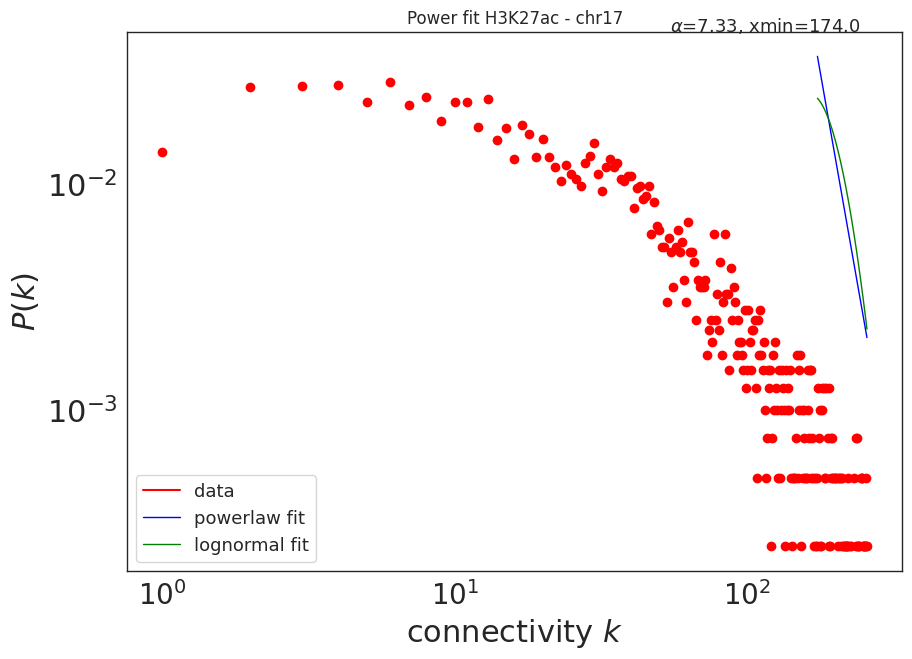

In [10]:
target = chrom17.obs['Target of assay'].unique()
for h in target:
    print(h)
    hm = chrom17[chrom17.obs['Target of assay']=='H3K4me3']
    hm_info = hm.obs
    hm = hm.to_df('average_signal')
    hm = filter_allzero(hm)

    rank_full = rank_transformation(hm)
    corr_full = correlation_cal(rank_full, 'pearsonr')
    print(corr_full.shape)
    
    power, _ = WGCNA.pickSoftThreshold(rank_full, 'unsigned')

    powerlaw_fit_plot(corr_df=corr_full, power=power, title=f'Power fit {h} - chr17')
    break

-----------------------
# GTEX plot

In [2]:
main_path = '/mnt/c/Users/linhn/OneDrive/Documents/Project BIOX7021/results/'
vertex_path = f'{main_path}vertex_df'
adj_path = f'{main_path}/adjacency_matrix'

In [116]:
#### GTEX variant files """
gtex_path = f'{main_path}GTEx_Analysis_v8_eQTL/'
files = os.listdir(gtex_path)
first_f = True
for f in files:
    if '.egenes' in f:
        tissue = f.split('.v8')[0]
        if first_f:
            gene_tested = pd.read_csv(f'{gtex_path}{f}', sep='\t', compression='gzip', engine='c')
            gene_tested['Tissue'] = [tissue]*len(gene_tested)
            first_f=False
        else:
            reading = pd.read_csv(f'{gtex_path}{f}', sep='\t', compression='gzip', engine='c')
            reading['Tissue'] = [tissue]*len(reading)
            gene_tested = pd.concat([gene_tested, reading])

In [257]:
gencode_v29 = pr.read_gtf('project/gencode.v29.annotation.gtf').df.query('Feature == "gene"')

In [453]:
overlap_tissue_gtex = ['Adrenal_Gland', 'Brain_Frontal_Cortex_BA9', 'Heart_Left_Ventricle', 'Colon_Sigmoid', 'Spleen', 'Stomach', 'Colon_Transverse', 'Adipose_Subcutaneous']

In [475]:
variant_set = gene_tested.query('~gene_chr.str.contains("X|Y") and qval<0.05')

In [476]:
variant_set.rename({
    'chr': 'Chromosome',
    'variant_pos': 'Start'
}, axis=1, inplace = True)
egenes_col = ['gene_id', 'gene_name', 'gene_chr', 'gene_start', 'gene_end','variant_id', 'tss_distance', 'Chromosome', 'Start', 'ref', 'alt','slope','qval', 'log2_aFC', 'Tissue']
egenes = variant_set[egenes_col]

In [477]:
egenes['End'] = egenes['Start']
egenes['abs_log2_aFC'] = abs(egenes['log2_aFC'])
egenes['abs_tss_distance'] = abs(egenes['tss_distance'])
egenes['abs_slope'] = abs(egenes['slope'])

In [478]:
distance_var_egenes = egenes.query('Start<gene_start or Start>gene_end')
distance_var_egenes = distance_var_egenes.query(f'Tissue in @overlap_tissue_gtex')
egenes = pr.PyRanges(egenes)
distance_var_egenes = pr.PyRanges(distance_var_egenes)

In [464]:
len(distance_var_egenes)

308587

------------------------------
# load wgcna df + gtex

In [10]:
list_wcgna = [x for x in os.listdir('.') if 'wgcna_region' in x]

In [11]:
scaler = MinMaxScaler()

In [29]:
h3k27ac = []
h3k4me3 = []
h3k4me1 = []
h3k27me3 = []
h3k9me3 = []

In [30]:
for f in list_wcgna:
    df = pd.read_feather(f).set_index('index')
    scaled = scaler.fit_transform(df[['connectivity']])
    df['connectivity'] = scaled
    if 'H3K27ac' in f:
        h3k27ac.append(df)
    elif 'H3K4me1' in f:
        h3k4me1.append(df)
    elif 'H3K4me3' in f:
        h3k4me3.append(df)    
    elif 'H3K27me3' in f:
        h3k27me3.append(df)
    elif 'H3K9me3' in f:
        h3k9me3.append(df)

In [31]:
h3k27ac = pd.concat(h3k27ac, axis=0)
h3k4me1 = pd.concat(h3k4me1, axis=0)
h3k4me3 = pd.concat(h3k4me3, axis=0)
h3k27me3 = pd.concat(h3k27me3, axis=0)
h3k9me3 = pd.concat(h3k9me3, axis=0)

In [32]:
network_dict = {
    'H3K27ac': h3k27ac,
    'H3K4me3': h3k4me3,
    'H3K4me1': h3k4me1,
    'H3K27me3': h3k27me3,
    'H3K9me3': h3k9me3
}

# GP visualize

In [ ]:
gp = GProfiler(return_dataframe=True)
for hm in network_dict.keys():
    if hm != 'H3K9me3':
        continue
    numb = len(network_dict[hm])
    regions_name = network_dict[hm].sort_values('connectivity', ascending=False).index[:round(numb*0.1)]
    
    c = [x.replace('-', ':') for x in regions_name]
    gene_enrich = gp.profile(organism='hsapiens',
                query=c)
    # gene_enrich.sort_values(['p_value', 'significant'])
    gene_enrich['region_ratio'] = gene_enrich['intersection_size']/gene_enrich['query_size'] 
    gene_enrich = gene_enrich.sort_values('intersection_size').iloc[:50, :]
    fig = px.scatter(gene_enrich, x='intersection_size', color='p_value', y='name', title=f'GProfiler Funtional Enrichment - Top connectivity regions - {hm}', size='region_ratio', symbol='source', width=1000, height=1000)
    fig.update_layout(coloraxis_colorbar=dict(len=0.3 ,ticks="outside"))
    fig.update_xaxes(title='Number of regions')
    fig.update_yaxes(title='', tickmode='linear')
    fig.show()
    # fig.write_image(f'{hm}_top_go_allchrom_wgcna.jpg')
    

In [16]:
def pyranges_from_df(df, index=True, col_name=None):
    if index:
        region = list_domain_todf(df.index.tolist()).reset_index().rename({'index': 'name'}, axis=1)
        region = region.merge(df, left_on='name', right_index=True)
    else:
        if not col_name:
            raise AttributeError
        else:
            region = list_domain_todf(df[col_name].tolist()).reset_index().rename({'index': 'name'}, axis=1)
        region = region.merge(df, left_on='name', right_on=col_name)
    region_pr = pr.PyRanges(region)
    return region_pr

In [17]:
import colorcet as cc

In [34]:
for hm in network_dict.keys():
    network_pr = pyranges_from_df(network_dict[hm])
    mutation_overlap = distance_var_egenes.nearest(network_pr, overlap=True).df
    check = mutation_overlap.query('Distance <=100')
    check['Chromosome'] = check['Chromosome'].astype('string')
    ols = check.groupby('name').agg({
        'connectivity': 'first',
        'abs_log2_aFC': max
    })
    ols_plot = px.scatter(check, y='connectivity', x='abs_log2_aFC', color='Chromosome', trendline='ols', title=f'Connectivity vs Max(absolute log2 aFC) - {hm}', height=1000, color_discrete_sequence=cc.glasbey)
    # ols_plot.show()
    ols_plot.write_image(f'{hm}_ols_plot.jpg')
    # var_dis = px.histogram(check, x='connectivity', y='abs_log2_aFC', histfunc='avg', facet_col='Chromosome', facet_col_wrap=5, height=1000)

In [35]:
from sklearn.linear_model import LinearRegression

In [578]:
df = []
for h in network_dict:
    network_dict[h]['Histone'] = h
    network_dict[h]['chrom'] = [x.split(':')[0] for x in network_dict[h].index.tolist()]
    df.append(network_dict[h].groupby(['Histone', 'dynamicColors', 'chrom']).size().reset_index())

-------------------

# BY TISSUE + gtex

In [330]:
hm = ['H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27ac']
vertex_files = os.listdir('network_dataframe_majortissue/vertex_df/')
hm_dict = {
    'H3K27me3': {}, 
    'H3K4me1': {}, 
    'H3K4me3': {}, 
    'H3K9me3': {}, 
    'H3K27ac': {}
}

for histone in hm:
    target_dict = {}
    files = [f for f in vertex_files if histone in f]
    for f in files:
        tissue = f.split('_')[1]
        if tissue not in hm_dict[histone]:
            hm_dict[histone][tissue] = []
        vertex_df = pd.read_feather(rf'network_dataframe_majortissue/vertex_df/{f}').set_index('vertex ID')
        vertex_df = vertex_df.query('degree>1')
        vertex_df['scaled_strength'] = scaler.fit_transform(vertex_df[['strength']])
        vertex_df['scaled_avg_strength'] = scaler.fit_transform(vertex_df[['average_strength']])
        vertex_df['scaled_degree'] = scaler.fit_transform(vertex_df[['degree']])
        hm_dict[histone][tissue].append(vertex_df)

In [331]:
for histone in hm:
    for tissue in hm_dict[histone]:
        hm_dict[histone][tissue] = pd.concat(hm_dict[histone][tissue], axis=0)

In [359]:
hm_dict['H3K4me3'].keys()

dict_keys(['heart right ventricle', 'sigmoid colon', 'spleen', 'transverse colon', 'stomach', 'heart left ventricle', 'adrenal gland', 'dorsolateral prefrontal cortex', 'subcutaneous abdominal adipose tissue'])

In [402]:
check = pyranges_from_df(hm_dict['H3K4me3']['dorsolateral prefrontal cortex'], index=False, col_name='name')

In [403]:
mutation = check.join(distance_var_egenes).df
# mutation = mutation.query('Distance<100')


In [438]:
ols = mutation.query('abs(tss_distance)>=100000').groupby(['name', 'Tissue']).agg({
    'Chromosome': 'first',
    'abs_log2_aFC': max,
    'scaled_avg_strength': 'first',
    'degree': 'first',
    'scaled_degree': 'first'
}).reset_index()

In [441]:
p_test =mutation.query('Tissue.str.contains("Frontal") and abs_log2_aFC >=0.5 and abs(tss_distance)>100000')
pearsonr(p_test['abs_log2_aFC'], p_test['scaled_avg_strength'])

PearsonRResult(statistic=0.5583648262168539, pvalue=0.01050579375990899)

In [435]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
def assign_rsquare(data, rsquare_df, index,
                   feature=['average_strength'], 
                   ftest_df=None,
                    pval_df=None,
                   result='log2_aFC', tss_dis=None, var_num=5):
    if not tss_dis:
        df = data.sort_values('Tissue').query('0.5 <= log2_aFC')
    else:
        lower, upper = tss_dis
        df = data.sort_values('Tissue').query(f'0.5 <= log2_aFC \
                            and {lower}<=abs(tss_distance)<={upper}')
    
    model = LinearRegression()
    score = {}
    for tissue in df.Tissue.unique():
        var = df.query(f'Tissue == "{tissue}"')
        if len(var) <=var_num or len(var) ==0:
            #print(len(var), index)
            continue
        X , y = var[feature], var[result]
        model.fit(X, y)
        #calculate R-squared of regression model
        r_squared = model.score(X, y)
        rsquare_df.loc[index, tissue] = r_squared
        
        
        # Fits the explainer
        explainer = shap.LinearExplainer(model, X)
        # Calculates the SHAP values - It takes some time
        score[tissue] = (explainer, X)

        if pval_df is not None:
            X = sm.add_constant(X)
            results=sm.OLS(y, X).fit()
            #print(results.pvalues)
            pval_df[f'{index}_{tissue}'] = results.pvalues
            if ftest_df is not None:
                ftest_df.loc[index, tissue] = results.f_pvalue

    return score

In [388]:
pair = []
for h in hm_dict:
    for t in hm_dict[h]:
        pair.append((h,t))

multiindex = pd.MultiIndex.from_tuples(pair)

In [515]:
rsquare_full= pd.DataFrame(0, index=multiindex, columns=overlap_tissue_gtex)
rsquare_100000 = rsquare_full.copy()
pvalue_full = {}
pvalue_100000 = {}
fscore = rsquare_full.copy()
fscore_100000 = rsquare_full.copy()

In [516]:
imp1={} #full
imp2={} #<100kb
features = ['scaled_avg_strength', 'evcent_modularity']
for h in hm_dict:
    for t in hm_dict[h]:
        vertex_df = hm_dict[h][t]
        vertex_pr = pyranges_from_df(vertex_df, index=False, col_name='name')

        var_full = variant_overlap(vertex_pr, vertex_df, distance_var_egenes)
        
        imp1[f'{h}_{t}'] = assign_rsquare(var_full, rsquare_full, (h, t), feature=features, var_num=7, pval_df=pvalue_full, ftest_df=fscore, tss_dis=(0, 100000))
        imp2[f'{h}_{t}'] = assign_rsquare(var_full, rsquare_100000, (h, t), feature=features, tss_dis=(100000, 5000000), var_num=7, pval_df=pvalue_100000, ftest_df=fscore_100000)

In [517]:
ylabel = [f'{x[0]}-{x[1]}' for x in rsquare_full.index.to_list()]
xlabel = rsquare_full.columns.to_list()

In [518]:
##### R-Square: LM: average_strength vs abs(log2_aFC) #########

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig1 = make_subplots(rows=2, cols=1,
                    subplot_titles=("Variants overlap with region and tss_distance<100kbp", "Variants overlap with region and tss_distance>100kbp"),
                    shared_yaxes=True)
colorsc = dict(colorscale='algae', showscale=False)
fig1.add_trace(go.Heatmap(z=rsquare_full.values,
                    y=ylabel,
                    x=xlabel,
                    colorscale='Viridis',
                    zmin=0.0, zmax=1.0, zmid=0.5,
                    colorbar=dict(title='r_square'),
                    hoverongaps = False),
                    row=1, col=1, )

fig1.add_trace(go.Heatmap(
                    z=rsquare_100000.values,
                    y=ylabel,
                    x=xlabel, 
                    colorscale='Viridis',
                    zmin=0.0, zmax=1.0, zmid=0.5,
                    colorbar=dict(title='r_square')),
                    row=2, col=1)

fig1.update_layout(height=2000, width=1500, title=f"LinearRegression:{features} vs abs(log2_aFC)")


fig1['layout']['yaxis']['dtick']=1
fig1['layout']['yaxis2']['dtick']=1



fig1.show()

visualize others 

In [18]:
size = []
for h in hm_dict:
    for t in hm_dict[h]:
        size.append((h, t, len(hm_dict[h][t])))

NameError: name 'hm_dict' is not defined

In [19]:
size_table = pd.DataFrame(size, columns=['Histone', 'Tissue', 'Number of regions'])

In [20]:
gencode_v29 = pr.read_gtf('project/gencode.v29.annotation.gtf').df.query('Feature.str.contains("gene|exon") and ~Chromosome.str.contains("X|Y|M")')

In [21]:
CREs = pd.read_csv('encodeCcreCombined.bed', sep='\t', names=['Chromosome', 'Start', 'End', 'name', 'score', 'strand', 'thickStart',
       'thickEnd', 'reserved', 'ccre', 'encodeLable', 'zscore', 'ucscLabel',
       'accessionLabel', 'description'])
CREs = pr.PyRanges(CREs)

In [22]:
geneann = gencode_v29.sort_values(['level']).drop_duplicates(['Feature', 'gene_id', 'exon_number'], keep='first')

In [24]:
geneann = pr.PyRanges(geneann)

In [205]:
top_dict = {}

In [206]:
gene

,name,Feature
235,chr22:26867692-26868691,-1
98,chr7:56396222-56397221,-1
99,chr7:56280222-56281221,-1
100,chr7:56277222-56278221,-1
101,chr7:56473222-56474221,-1
...,...,...
116,chr10:38120107-38121106,gene
115,chr10:38117107-38118106,gene
102,chr7:55860222-55861221,gene
72,chr6:61753326-61754325,gene


In [209]:
for h in network_dict:
    top = network_dict[h].sort_values('connectivity', ascending=False).iloc[: 200]
    top_pr = pyranges_from_df(top)
    gene = top_pr.join(geneann, how='left').df.sort_values('Feature').drop_duplicates('name', keep='first')[['name', 'Feature']]
    ccr = gene.query('Feature =="-1"').name.tolist()
    reg= top_pr.join(CREs, how='left').df.groupby('name').agg({
        'encodeLable': list,
        'connectivity':'first'
    }).loc[ccr, :]
    top_dict[h] = [gene, reg]

In [228]:
x = top_dict['H3K4me1'][0].set_index('name').join(top_dict['H3K4me1'][1], how='left')

In [232]:
x['ann'] = np.where(x['Feature']!='-1', x['Feature'], x['encodeLable'])

In [233]:
x

,Feature,encodeLable,connectivity,ann
name,,,,
chr22:48238214-48239213,-1,[-1],0.967465,[-1]
chr15:57816745-57817744,-1,[-1],1.000000,[-1]
chr13:77470837-77471836,-1,[-1],1.000000,[-1]
chr8:40155836-40156835,-1,"[dELS, dELS, dELS]",0.948824,"[dELS, dELS, dELS]"
chr11:130668949-130669948,-1,[-1],0.977560,[-1]
...,...,...,...,...
chr11:79129180-79130179,gene,NaN,NaN,gene
chr11:123180353-123181352,gene,NaN,NaN,gene
chr11:83774418-83775417,gene,NaN,NaN,gene


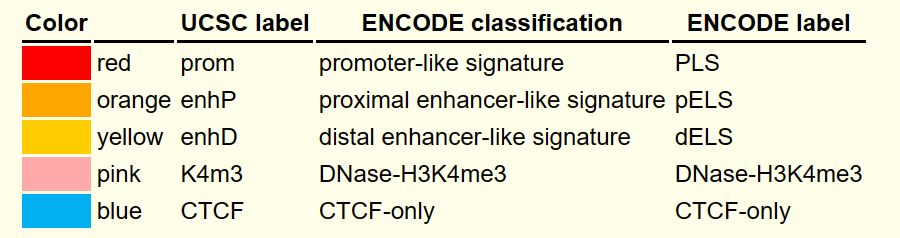

In [234]:

fig = px.pie(x.replace('gene', 'intron'), names='ann', title='Genomic Annotation H3K4me1', width=800)
fig.update_traces(hoverinfo='percent+value',textinfo='value')
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()